In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# %matplotlib widget

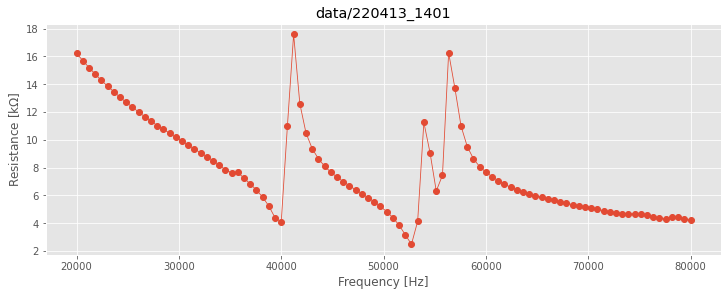

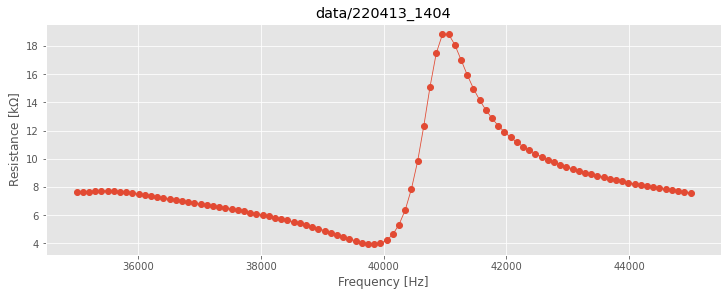

In [ ]:
plt.close("all")
dirs = list(Path("data").glob("[!.]*"))
dirs.sort()
for in_dir in dirs:
    files = list(in_dir.glob("*.csv"))
    files.sort()

    rms_in_arr = []
    rms_out_arr = []
    freq_arr = []
    res_arr = []

    for file in files:
        freq = float(file.stem.split("_")[1])
        data = np.loadtxt(file, delimiter=",")

        rms_out, rms_in = np.sqrt((data**2).mean(axis=0))
        res = 1000 * (rms_in / rms_out - 1)

        freq_arr.append(freq)
        rms_in_arr.append(rms_in)
        rms_out_arr.append(rms_out)
        res_arr.append(res)
    
    res_arr = np.array(res_arr)

    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    ax.plot(freq_arr, res_arr/1000, marker="o")
    ax.set_title(in_dir)
    # ax.set_xscale("log")
    ax.grid(True, "both")
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"Resistance [k$\Omega$]")
    plt.show()